In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from glob import glob
from IPython.display import clear_output
from matplotlib import ticker
from scipy.stats import gmean
from sklearn.metrics import confusion_matrix
from src.data.synthetic_gen import DataLoader
from src.models.classification import NeuralNetClassifier
from src.models.classification.evaluate_models import ClassificationAnalysis
from src.models.classification.train_models import ClassificationTraining
from src.visualization.styles.formatting import errorbar_kwargs

tf.random.set_seed(13)

In [2]:
dataset_size = 2

dl = DataLoader(problem="classification", dataset_size=dataset_size)
datasets, minmax = dl.load_cross_validation_datasets()

train_data = datasets["train"]
valid_data = datasets["valid"]

### Training best neural network

- Model: Rede Neural #11
- Parameters
    - hidden units: [128, 128]
    - activation: relu
    - learning rate: 0.001
    - epochs: 500
    - batch size: 32

In [3]:
# Train best neural network
# Rede Neural #11
learning_rate = 0.001
epochs = 500
batch_size = 32

params = {"hidden_units": [128, 128], "activation": "relu"}

models = []
for i, (train, valid) in enumerate(zip(train_data, valid_data)):

    train_features, train_labels = train["features"], train["targets"]
    valid_features, valid_labels = valid["features"], valid["targets"]

    features, labels = train_features.values, train_labels.values
    train_ds = (
        tf.data.Dataset.from_tensor_slices((features, labels))
        .shuffle(10000)
        .batch(batch_size)
    )

    features, labels = valid_features.values, valid_labels.values
    valid_ds = tf.data.Dataset.from_tensor_slices((features, labels)).batch(batch_size)

    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    accuracy = tf.keras.metrics.CategoricalAccuracy()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(),
        # patience 10% of epochs size
        tf.keras.callbacks.EarlyStopping(min_delta=0.0001, patience=50),
    ]
    model = NeuralNetClassifier(**params)
    model.compile(optimizer=optimizer, loss=loss_object, metrics=[accuracy])
    h = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=valid_ds,
        callbacks=callbacks,
        verbose=1,  # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
    )

    models.append(model)

    models_folder = os.path.join("notebooks", "classification_models", f"{dataset_size}to1")
    if not os.path.isdir(models_folder):
        os.makedirs(models_folder)

    model.save(os.path.join(models_folder, f"model_fold={i+1}.keras"))
    clear_output(wait=True)

Epoch 1/500
666/666 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - categorical_accuracy: 0.8910 - loss: 0.2708 - val_categorical_accuracy: 0.9598 - val_loss: 0.0937 - learning_rate: 0.0010
Epoch 2/500
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - categorical_accuracy: 0.9797 - loss: 0.0592 - val_categorical_accuracy: 0.9858 - val_loss: 0.0639 - learning_rate: 0.0010
Epoch 3/500
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - categorical_accuracy: 0.9823 - loss: 0.0495 - val_categorical_accuracy: 0.9740 - val_loss: 0.0649 - learning_rate: 0.0010
Epoch 4/500
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - categorical_accuracy: 0.9826 - loss: 0.0421 - val_categorical_accuracy: 0.9811 - val_loss: 0.0633 - learning_rate: 0.0010
Epoch 5/500
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - categorical_accuracy: 0.9877 - loss: 0.0372 - val_categorical_accuracy: 0.9740 - val_loss: 0.0654 - learning_rate: 0.0010
Epoch 6/500
666/666 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - categorical_accuracy: 0.9853 - loss: 0.0376 - val_

### Evaluation

In [25]:
# Load saved models trained with synthetic dataset
def calculate_performances_values(folder, dataset_size):
    models = [tf.keras.models.load_model(model_file) for model_file in glob(os.path.join(folder, "*.keras"))]

    confusion_matrix_values = []
    accuracies = []
    sensitivities = []
    sp_indexes = []

    for valid, model in zip(valid_data, models):
        valid_features, valid_labels = valid["features"], valid["targets"]

        X_valid = tf.convert_to_tensor(valid_features)
        probs = tf.convert_to_tensor(valid_labels)
        y_valid = tf.argmax(probs, axis=1)

        logits = model(X_valid)
        probs_hat = tf.nn.softmax(logits)
        y_valid_hat = tf.argmax(probs_hat, axis=1)

        # Confusion matrix
        cm = confusion_matrix(y_valid, y_valid_hat)
        confusion_matrix_values.append(cm)

        # Accuracy
        accuracies.append(np.diag(cm).sum() / cm.sum())

        # Sensitivity
        sens = np.diag(cm) / cm.sum(axis=1)
        sensitivities.append(sens)

        # SP Index
        sp_indexes.append(np.sqrt(np.mean(sens) * gmean(sens)))

    confusion_matrix_values = np.array(confusion_matrix_values)
    accuracies = np.array(accuracies)
    sensitivities = np.array(sensitivities)
    sp_indexes = np.array(sp_indexes)

    print(f"Dataset {dataset_size}to1")
    print(f"Accuracy = {(100 * accuracies).mean():.2f} +/- {(100 * accuracies).std() / np.sqrt(10 - 1):.2f} %")

    mean_sens = (100 * sensitivities).mean(axis=0)
    std_err_sens = (100 * sensitivities).std(axis=0) / np.sqrt(10 - 1)
    print(f"Sensitivity [V] = {mean_sens[0]:.2f} +/- {std_err_sens[0]:.2f} %")
    print(f"Sensitivity [VL] = {mean_sens[1]:.2f} +/- {std_err_sens[1]:.2f} %")
    print(f"Sensitivity [L] = {mean_sens[2]:.2f} +/- {std_err_sens[2]:.2f} %")

    print(f"SP Index = {(100 * sp_indexes).mean():.2f} +/- {(100 * sp_indexes).std() / np.sqrt(10 - 1):.2f} %")
    print()

    return {
        "confusion_matrix": confusion_matrix_values,
        "accuracies": accuracies,
        "sensitivities": sensitivities,
        "sp_indexes": sp_indexes
    }

models_folder_1to1 = os.path.join("notebooks", "classification_models", "1to1")
models_folder_2to1 = os.path.join("notebooks", "classification_models", "2to1")

indices_1to1 = calculate_performances_values(models_folder_1to1, 1)
indices_2to1 = calculate_performances_values(models_folder_2to1, 2)

Dataset 1to1
Accuracy = 99.13 +/- 0.12 %
Sensitivity [V] = 98.97 +/- 0.23 %
Sensitivity [VL] = 98.84 +/- 0.20 %
Sensitivity [L] = 99.58 +/- 0.15 %
SP Index = 99.13 +/- 0.12 %

Dataset 2to1
Accuracy = 99.37 +/- 0.11 %
Sensitivity [V] = 99.33 +/- 0.23 %
Sensitivity [VL] = 99.18 +/- 0.17 %
Sensitivity [L] = 99.58 +/- 0.11 %
SP Index = 99.36 +/- 0.11 %



In [6]:
samples_per_composition = 30

training = ClassificationTraining(samples_per_composition=samples_per_composition)
analysis = ClassificationAnalysis(samples_per_composition=samples_per_composition)

results = training.load_training_models()
indices = analysis.load_performance_indices()

In [7]:
model_name = "Rede Neural #11"
output = [out for out in results["outputs"] if out["model_name"] == model_name][0]
model_id = [i for i, out in enumerate(results["outputs"]) if out["model_name"] == model_name][0]

print(f"Modelo: {output['model_name']}, ID: {model_id}")
print("    params:", output["params"])
print("    opt:   ", output["opt"])

Modelo: Rede Neural #11, ID: 28
    params: {'hidden_units': [128, 128], 'activation': 'relu'}
    opt:    {'lr': 0.001, 'epochs': 500, 'batch_size': 32}


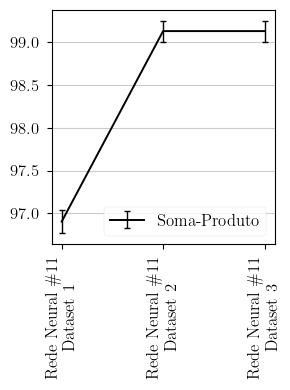

In [26]:
name = model_name.replace('#', '\#')

labels = [
    f"{name}\nDataset 1", 
    f"{name}\nDataset 2", 
    f"{name}\nDataset 3"]
x = np.array([1, 2, 3])

f, ax = plt.subplots(figsize=(3, 4))

sp_indexes_1to1 = indices_1to1["sp_indexes"]
sp_indexes_2to1 = indices_1to1["sp_indexes"]

sp_idx = np.c_[indices["sp_index"][:, model_id], sp_indexes_1to1, sp_indexes_2to1]

y = sp_idx.mean(axis=0) * 100
y_err = (sp_idx.std(axis=0) / np.sqrt(10 - 1)) * 100
ax.errorbar(x, y, y_err, label="Soma-Produto", **errorbar_kwargs)
ax.yaxis.grid()
ax.set_xticks(x, labels, rotation=90, ha="center")
ax.legend(loc="lower right")

f.tight_layout()
plt.savefig(os.path.join("data", "images", "sp_index_errorbar_plot_synthetic.png"), dpi=600)
plt.show()

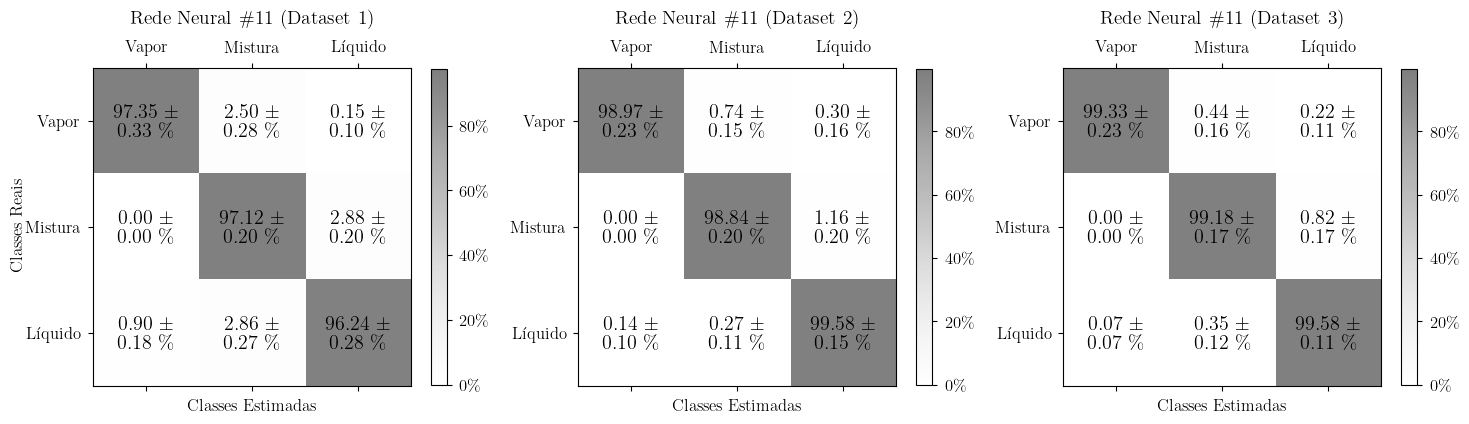

In [27]:
def plot_confusion_matrix(cm, ax, model_name):
    cm = cm / np.sum(cm, axis=2)[:, :, None]
    cm_mean = np.mean(cm, axis=0)
    cm_std = np.std(cm, axis=0) / np.sqrt(10 - 1)

    ms = ax.matshow(cm_mean, alpha=0.5, cmap="Greys")
    for ii in range(cm_mean.shape[0]):
        for jj in range(cm_mean.shape[1]):
            text = f"{cm_mean[ii, jj] * 100:1.2f} \\textpm \n {cm_std[ii, jj] * 100:1.2f} \%"
            ax.text(x=jj, y=ii, s=text, va="center", ha="center", size="x-large")

    cbar = ax.figure.colorbar(ms, ax=ax, shrink=0.675, format=ticker.PercentFormatter(xmax=1))
    ax.set_xlabel("Classes Estimadas")
    # ax.set_ylabel("Classes Reais")
    ax.set_title(model_name.replace("#", "\#"))

    # 0: gas, 1: mix, 2: oil
    ax.set_xticks([0, 1, 2], ["Vapor", "Mistura", "Líquido"])
    ax.set_yticks([0, 1, 2], ["Vapor", "Mistura", "Líquido"])
    ax.grid(False)

f, axs = plt.subplots(1, 3, figsize=(15, 5))

cm_real = indices["confusion_matrix"][:, model_id, :, :].astype("int16")
cm_synthetic_1to1 = indices_1to1["confusion_matrix"].astype("int16")
cm_synthetic_2to1 = indices_2to1["confusion_matrix"].astype("int16")
plot_confusion_matrix(cm_real, axs[0], f"{model_name} (Dataset 1)")
plot_confusion_matrix(cm_synthetic_1to1, axs[1], f"{model_name} (Dataset 2)")
plot_confusion_matrix(cm_synthetic_2to1, axs[2], f"{model_name} (Dataset 3)")

f.supylabel("Classes Reais")
f.tight_layout()

plt.savefig(os.path.join("data", "images", "comparing_confusion_matrices_synthetic.png"), dpi=600)
plt.show()